In [78]:
## Importing libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score

In [79]:
## Data Cleaning
sample_data = pd.read_csv('../EXAM/data/cleaned_data.csv',encoding='utf-16')
df = pd.DataFrame(sample_data)

In [80]:
## Dataset split
columns_to_drop = ['price','address','city','type','energy', 'year','area_name', 'age_squared', 'area_code','area_digit_1','area_digit_2','area_digit_3','area_digit_4','area_digit_5','area_digit_6','area_digit_7','area_digit_8','area_digit_9','owner_expenses']
X,y = df.drop(columns_to_drop,axis=1),df.price
test_size = 0.30 # taking 70:30 training and test set
seed = 17082023 # Random number seeding for repeatability of the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
print(X.columns)

Index(['saledays', 'living_space', 'ground_space', 'rooms', 'Apartment',
       'Holiday home', 'Terraced house', 'Villa', 'land', 'Energimærke A',
       'Energimærke B', 'Energimærke C', 'Energimærke D', 'Energimærke E',
       'Energimærke F', 'Energimærke G', 'age', 'Bornholm', 'Byen København',
       'Fyn', 'Københavns omegn', 'Nordjylland', 'Nordsjælland', 'Sydjylland',
       'Vest- og Sydsjælland', 'Vestjylland', 'Østjylland', 'Østsjælland'],
      dtype='object')


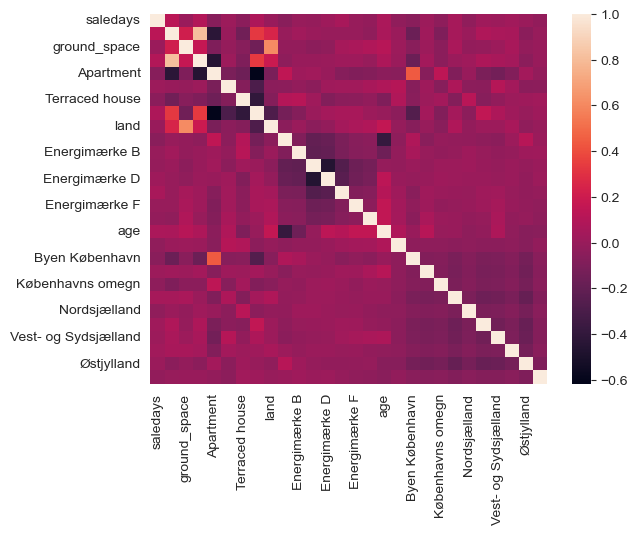

In [81]:
## Heat map
XcorrHeat = sns.heatmap(X.corr())
fig = XcorrHeat.get_figure()
plt.savefig('../EXAM/figs/Xvar_corr_heat_map.png', bbox_inches='tight')

In [82]:
## Main model
param = {
    'random_state': seed
}

gradient_booster = GradientBoostingRegressor(**param)


# Gradient boosting classifiers are required to implement gradient boosting.
gradient_booster.fit(X_train,y_train)
y_test_predict = gradient_booster.predict(X_test)

In [83]:
## R-squared
r2_GBM = r2_score(y_test,y_test_predict)
r2_GBM

0.281718352887973

In [84]:
## RMSE
RMSE_GBM = mse(y_test,y_test_predict,squared=False)
RMSE_GBM

2643662.583322321

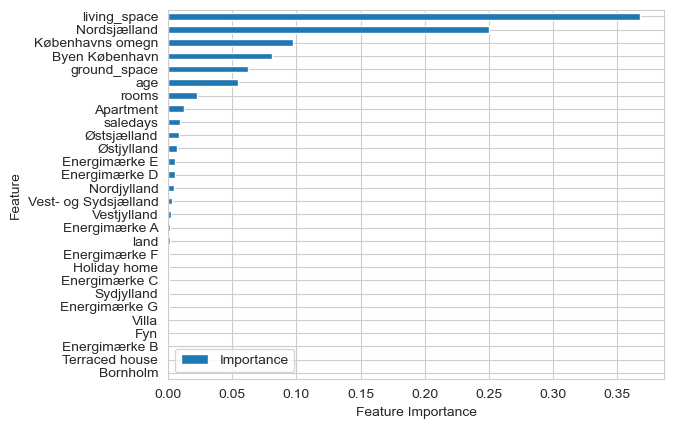

In [85]:
feat_imp_dict = pd.DataFrame([gradient_booster.feature_importances_,X.columns]).T
feat_imp_dict.columns = ['Importance','Feature']
feat_imp_dict = feat_imp_dict.set_index('Feature',drop=True)\
                            .sort_values(by='Importance',ascending=True)
feat_imp_dict.plot(kind="barh")
plt.xlabel('Feature Importance')
plt.savefig('../EXAM/figs/GBM_feature_importance-baseline', bbox_inches='tight')
plt.show()

In [86]:
## Define hyperpara
param_grid = {
    # Tree param
    'max_depth': [1, 2, 3, 4],
    'min_samples_leaf': list(range(10,100,20)),
    # Boost param
    'learning_rate': [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6],
    # Miscellaneous param
    'random_state':seed
}

In [87]:
## 10-fold cross validation
num_folds = 10
kfolds = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

best_score = float('-inf')
best_params = {}

for min_samples_leaf in param_grid['min_samples_leaf']:
    for max_depth in param_grid['max_depth']:
        for learning_rate in param_grid['learning_rate']:
            params = {
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                # Boost param
                'learning_rate': learning_rate,
                # Miscellaneous param
                'random_state':seed
            }

        model = GradientBoostingRegressor(**params)
        scores = cross_val_score(model, X_train, y_train, cv=kfolds, scoring='neg_mean_squared_error')
        avg_score = np.mean(scores)

        if avg_score > best_score:
            best_score = avg_score
            best_params = params

print('Best Parameters:', best_params)
print('Best Train Score:', np.sqrt(-best_score)) # Convert back to positive mean squared error

# Fitting the model with best para
final_model = GradientBoostingRegressor(**best_params)
final_model.fit(X_train, y_train)

y_test_predict = final_model.predict(X_test)

Best Parameters: {'max_depth': 2, 'min_samples_leaf': 90, 'learning_rate': 1.6, 'random_state': 17082023}
Best Train Score: 2588673.751900883


In [88]:
## R-squared
r2_GBM = r2_score(y_test,y_test_predict)
r2_GBM

0.37865026341058494

In [89]:
## RMSE
RMSE_GBM = mse(y_test,y_test_predict,squared=False)
RMSE_GBM

2458819.783122914

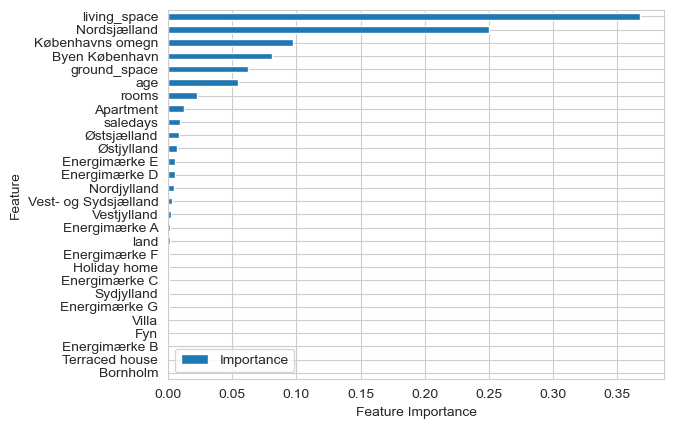

In [90]:
# Feature Importance
feat_imp_dict = pd.DataFrame([gradient_booster.feature_importances_,X.columns]).T
feat_imp_dict.columns = ['Importance','Feature']
feat_imp_dict = feat_imp_dict.set_index('Feature',drop=True)\
                            .sort_values(by='Importance',ascending=True)
feat_imp_dict.plot(kind="barh")
plt.xlabel('Feature Importance')
plt.savefig('../EXAM/figs/GBM_feature_importance',bbox_inches='tight')
